In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/w266')

In [3]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from transformers import AutoTokenizer,TFAutoModel,TFAutoModelForSequenceClassification
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

import torch
from torch.utils.data import DataLoader, Dataset


# Load Data

In [ ]:
news=pd.read_csv('reuters_headlines.csv').dropna()
news.shape

(32770, 3)

In [ ]:
news['Time']=pd.to_datetime(news['Time'])

In [ ]:
news.head()

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,2020-07-18,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,2020-07-18,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,2020-07-18,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,2020-07-18,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,2020-07-17,A battle in the U.S. Congress over a new coron...


In [ ]:
p=pd.read_csv('price_of_major_assets.csv',index_col=0,parse_dates=True)['stock']

In [ ]:
r=np.log(p.ffill()).diff().shift(-1) # we need to predict next day's change

In [ ]:
combined=news.merge(r.reset_index(),left_on='Time',right_on='Date') # join the news with stock price chagne

In [ ]:
combined.drop('Date',axis=1,inplace=True)
combined=combined.sort_values('Time')

In [ ]:
combined.tail()

,Headlines,Time,Description,stock
30645,Malaysia says never hired British data firm at...,2018-03-20,The Malaysian government and the ruling party ...,-0.001846
30646,Prosecutors search Volkswagen headquarters in ...,2018-03-20,German prosecutors said on Tuesday they had se...,-0.001846
30647,McDonald's sets greenhouse gas reduction targets,2018-03-20,McDonald's Corp on Tuesday announced an approv...,-0.001846
30648,Pratt & Whitney to deliver spare A320neo engin...,2018-03-20,Pratt & Whitney will soon begin deliveries of ...,-0.001846
30649,UK will always consider ways to improve data l...,2018-03-20,Britain will consider any suggestions to give ...,-0.001846


# Load Pre-trained Model

In [ ]:
checkpoint = 'yiyanghkust/finbert-tone'
# This is a bert model fine-tuned with financial news and articles. It can output sentiments(POSTIVE, NERUTRAL and NEGATIVE) directly
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)
model_class = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

In [ ]:
def count_words(text):
    words = text.split()
    return len(words)

combined['Description'].apply(count_words).describe()
# the word count shows MAX_SEQUENCE_LENGTH=100 may be enough

count    30650.000000
mean        34.399184
std          6.731292
min          7.000000
25%         30.000000
50%         35.000000
75%         39.000000
max         88.000000
Name: Description, dtype: float64

In [ ]:
MAX_SEQUENCE_LENGTH=100

In [ ]:
text=combined['Description'].to_list()
text_tokenized = tokenizer(text,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

In [ ]:
# get the output from the pretrained model
output=model_class.predict([text_tokenized['input_ids'],text_tokenized['attention_mask']])

In [ ]:
probs = tf.nn.softmax(output['logits'], axis=-1)

In [ ]:
combined[['prob_netrual','prob_positive','prob_negative']]=probs
combined['sentiment']=np.argmax(probs,axis=1)
combined['sentiment'].replace({2:0,0:1,1:2},inplace=True) #adjust the levels
combined['prob_diff']=combined['prob_positive']-combined['prob_negative']

In [ ]:
combined.to_csv("reuters_news_with_prob.csv",index=False)

# Solution 1: averaging the sentiment for the same date

In [ ]:
sentiment_daily=combined.groupby('Time')['prob_diff'].mean()

In [ ]:
sentiment_daily['signal_pretrained']=np.sign(sentiment_daily['prob_diff'])

# Solution 2: fine-tuning with logits

In [ ]:
combined.groupby('Time')['Description'].count().describe()

count    609.000000
mean      50.328407
std       15.933265
min        4.000000
25%       40.000000
50%       50.000000
75%       58.000000
max      126.000000
Name: Description, dtype: float64

In [ ]:
y=combined.groupby('Time')['stock'].last()

In [ ]:
combined.groupby('Time')['Description'].count().describe()

count    609.000000
mean      50.328407
std       15.933265
min        4.000000
25%       40.000000
50%       50.000000
75%       58.000000
max      126.000000
Name: Description, dtype: float64

In [ ]:
combined.groupby('Time')['Description'].count().quantile(0.95) # choose a maxium of 80 news per day

80.0

In [ ]:
MAX_X_LEN=80
x_all=[]
for i in y.index:
  x=combined[combined['Time']==i][['prob_negative','prob_netrual','prob_positive']].to_numpy()
  if x.shape[0]<MAX_X_LEN:
    x=x.copy()
    x.resize((MAX_X_LEN,3)) # if there are less than 80 news, we need to pad
    x_all.append(x)
  else:
    x_all.append(x[:MAX_X_LEN,:]) # if there are more than 80 news, we need to cut

In [ ]:
x_all=np.array(x_all)

In [ ]:
x_all.shape

(609, 80, 3)

In [ ]:
np.save('padded_x.npy',np.array(x_all))

In [ ]:
train_size=round(y.shape[0]*0.8)
train_size

487

In [ ]:
train_x=x_all[:train_size]
test_x=x_all[train_size:]

In [ ]:
train_y=y[:train_size].to_numpy()
test_y=y[train_size:].to_numpy()

In [ ]:
from tensorflow.keras.layers import Layer, Input, Dense, LSTM, Attention
from tensorflow.keras.models import Model, Sequential

class SelfAttentionLayer(Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        super(SelfAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name='W_q',
                                   shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.W_k = self.add_weight(name='W_k',
                                   shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   trainable=True)
        self.W_v = self.add_weight(name='W_v',
                                   shape=(input_shape[-1], self.units),
                                   initializer='glorot_uniform',
                                   trainable=True)
        super(SelfAttentionLayer, self).build(input_shape)

    def call(self, x):
        Q = tf.matmul(x, self.W_q)
        K = tf.matmul(x, self.W_k)
        V = tf.matmul(x, self.W_v)

        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        output = tf.matmul(attention_weights, V)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
def create_model_with_attention(max_input_len=MAX_X_LEN,dropout=0.3,hidden_dim=32,learning_rate=0.005):
  input= tf.keras.layers.Input(shape=(max_input_len,3))
  attention=SelfAttentionLayer(units=16,input_shape=(max_input_len,3))(input)
  attention_flatten=tf.keras.layers.Flatten()(attention)
  hidden=tf.keras.layers.Dense(hidden_dim,)(attention_flatten)
  droput=tf.keras.layers.Dropout(dropout)(hidden)
  reg=tf.keras.layers.Dense(1)(droput)
  wan_model = tf.keras.models.Model(inputs=[input], outputs=[reg])
  wan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='mse')
  return wan_model

In [ ]:
model_with_attention=create_model_with_attention()

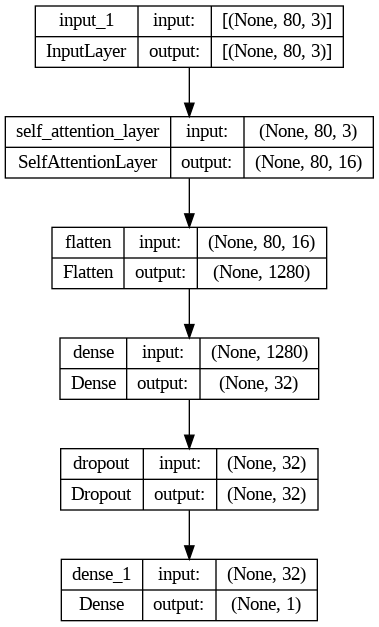

In [ ]:
tf.keras.utils.plot_model(model_with_attention,show_shapes=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, mode="auto", restore_best_weights=True
    )

In [ ]:
hist_model_using_logits=model_with_attention.fit(
    train_x,
    train_y,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=early_stopping
)

Epoch 1/20
13/13 [==============================] - 0s 21ms/step - loss: 0.1994 - val_loss: 0.0955
Epoch 2/20
13/13 [==============================] - 0s 19ms/step - loss: 0.0361 - val_loss: 0.0022
Epoch 3/20
13/13 [==============================] - 0s 24ms/step - loss: 0.0139 - val_loss: 0.0044
Epoch 4/20
13/13 [==============================] - 0s 25ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 5/20
13/13 [==============================] - 0s 23ms/step - loss: 0.0033 - val_loss: 9.8754e-04
Epoch 6/20
13/13 [==============================] - 0s 26ms/step - loss: 0.0028 - val_loss: 9.5157e-04
Epoch 7/20
13/13 [==============================] - 0s 20ms/step - loss: 0.0020 - val_loss: 8.7435e-04
Epoch 8/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 8.2365e-04
Epoch 10/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 

<Axes: >

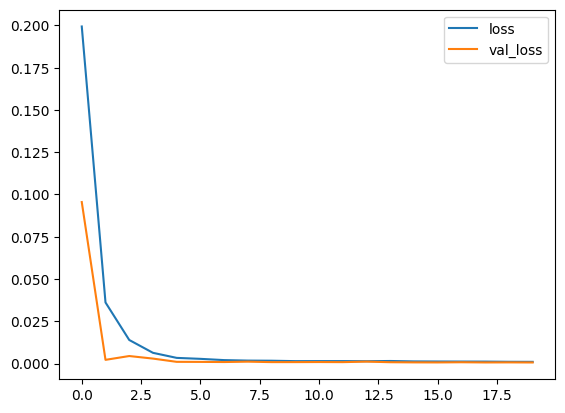

In [ ]:
pd.DataFrame(hist_model_using_logits.history).plot()

In [ ]:
predicts=model_with_attention.predict(test_x)

4/4 [==============================] - 0s 8ms/step


In [ ]:
model_with_attention.evaluate(test_x,test_y)

4/4 [==============================] - 0s 6ms/step - loss: 0.0016


0.0015547297662124038

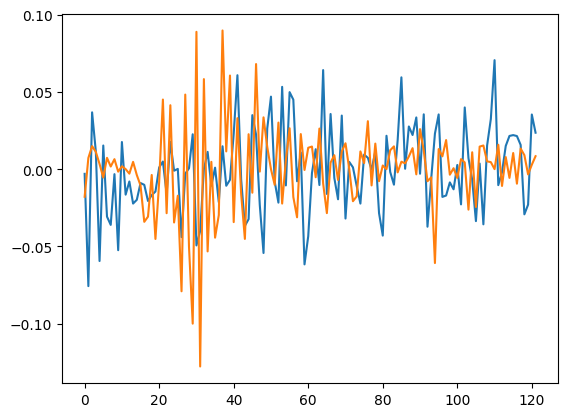

In [ ]:
plt.plot(predicts)
plt.plot(test_y)

In [ ]:
test_y_df=pd.DataFrame(y[train_size:])

In [ ]:
test_y_df['predict']=predicts

In [ ]:
test_y_df['pos_quantile']=pd.qcut(test_y_df['predict'],[0,0.2,0.8,1],labels=False)-1
test_y_df['pos_sign']=np.sign(test_y_df['predict'])

In [ ]:
test_y_df.to_csv('shallow_fine_tune.csv')

# Solution 3: fine-tune with pooler

## Get the pooler output for each news

In [ ]:
def extract_pooler(model):
  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')
  input={'input_ids': input_ids, 'attention_mask': attention_mask}
  pooler_layer=model(input)['pooler_output']
  extract_model = tf.keras.Model(inputs=[input], outputs=[pooler_layer])
  return extract_model

In [ ]:
extract_model=extract_pooler(model)

In [ ]:
output=extract_model.predict([text_tokenized['input_ids'],text_tokenized['attention_mask']])

958/958 [==============================] - 208s 212ms/step


In [ ]:
output.shape

(30650, 768)

In [ ]:
np.save('pooler_output',output)

In [ ]:
# we basically follow the process before, only this time the input has dim of 768 instead of 3, so we need to shorten the num of news per day
MAX_X_LEN=50
x_all=[]
for i in y.index:
  x=output[combined['Time']==i]
  if x.shape[0]<MAX_X_LEN:
    x=x.copy()
    x.resize((MAX_X_LEN,768))
    x_all.append(x)
  else:
    x_all.append(x[:MAX_X_LEN,:])

In [ ]:
x_all=np.array(x_all)

In [ ]:
np.save('padded_pooler_x.npy',x_all)

In [ ]:
train_x=x_all[:train_size]
test_x=x_all[train_size:]

In [ ]:
train_y=y[:train_size].to_numpy()
test_y=y[train_size:].to_numpy()

In [ ]:
def create_model_with_attention(max_input_len=MAX_X_LEN,dropout=0.3,hidden_dim=32,learning_rate=0.005):
  input= tf.keras.layers.Input(shape=(max_input_len,768))
  attention=SelfAttentionLayer(units=64,input_shape=(max_input_len,768))(input)
  attention_flatten=tf.keras.layers.Flatten()(attention)
  # hidden=tf.keras.layers.Dense(hidden_dim,)(attention_flatten)
  droput=tf.keras.layers.Dropout(dropout)(attention_flatten)
  reg=tf.keras.layers.Dense(1)(droput)
  wan_model = tf.keras.models.Model(inputs=[input], outputs=[reg])
  wan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='mse')
  return wan_model

In [ ]:
model_with_attention=create_model_with_attention()

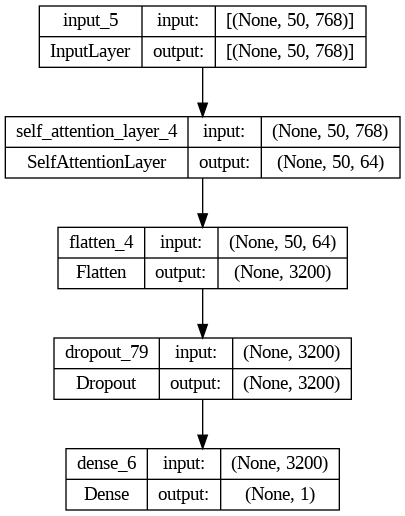

In [ ]:
tf.keras.utils.plot_model(model_with_attention,show_shapes=True)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, mode="auto", restore_best_weights=True
    )

In [ ]:
hist_model_using_logits=model_with_attention.fit(
    train_x,
    train_y,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=early_stopping
)

Epoch 1/50
13/13 [==============================] - 1s 19ms/step - loss: 42.4032 - val_loss: 9.7868
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 5.4022 - val_loss: 4.3268
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 2.2372 - val_loss: 0.3306
Epoch 4/50
13/13 [==============================] - 0s 9ms/step - loss: 0.6527 - val_loss: 0.0380
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.1807 - val_loss: 0.0328
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.1079 - val_loss: 0.0089
Epoch 7/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0840 - val_loss: 0.0029
Epoch 8/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0485 - val_loss: 0.0020
Epoch 9/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0391 - val_loss: 0.0016
Epoch 10/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0364 - val_loss: 0.0018
Epoch 11/50
13

<Axes: >

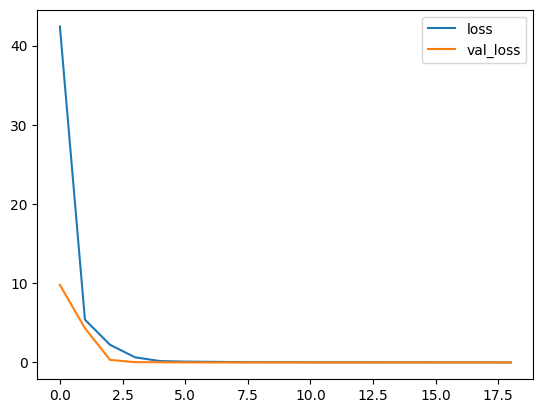

In [ ]:
pd.DataFrame(hist_model_using_logits.history).plot()

In [ ]:
predicts=model_with_attention.predict(test_x)

4/4 [==============================] - 0s 7ms/step


In [ ]:
model_with_attention.evaluate(test_x,test_y)

4/4 [==============================] - 0s 6ms/step - loss: 0.0021


0.0021211951971054077

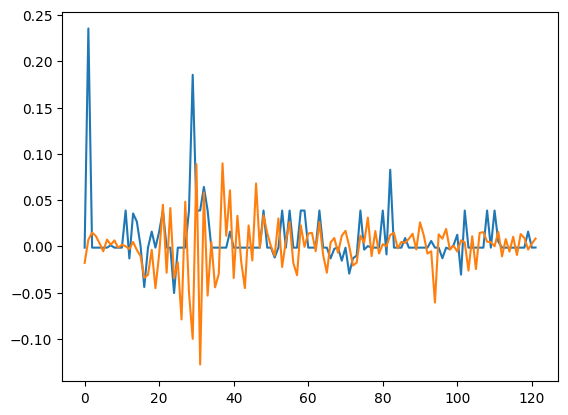

In [ ]:
plt.plot(predicts)
plt.plot(test_y)

In [ ]:
test_y_df=pd.DataFrame(y[train_size:])

In [ ]:
test_y_df['predict']=predicts

In [ ]:
test_y_df['pos_quantile']=pd.qcut(test_y_df['predict'],[0,0.2,0.8,1],labels=False)-1
test_y_df['pos_sign']=np.sign(test_y_df['predict'])

In [ ]:
test_y_df.to_csv('deep_fine_tune.csv')